# Chapter 003 Examples 004

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import cross_val_score
import json as js
import pandas as pd
import os
import shutil

In [2]:
dirInName=os.path.relpath('../../data')
dirOutName=os.path.relpath('./data')
if not os.path.exists(dirOutName):
    os.makedirs(dirOutName)
    print('Make:', dirOutName)
else:
    print('Have:', dirOutName)

Have: data


In [3]:
datafilelist = ('sickness02.csv', 'Homes02.csv')
for datafile in datafilelist:
    fileIn = os.path.join(dirInName, datafile)
    fileOut = os.path.join(dirOutName, datafile)
    print('Copy : %s to %s' % (fileIn, fileOut))
    shutil.copyfile(fileIn, fileOut)

Copy : ..\..\data\sickness02.csv to data\sickness02.csv
Copy : ..\..\data\Homes02.csv to data\Homes02.csv


In [4]:
rng = np.random.RandomState(123)

In [5]:
sickdf= pd.read_csv(os.path.abspath('./data/sickness02.csv'),header=0)
print(sickdf.shape)
print(sickdf.columns)

(303, 14)
Index(['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10',
       'F11', 'F12', 'F13', 'T'],
      dtype='object')


In [6]:
homesdf= pd.read_csv(os.path.abspath('./data/Homes02.csv'),header=0)
print(homesdf.shape)
print(homesdf.columns)

(21613, 5)
Index(['F01', 'F02', 'F03', 'F04', 'T'], dtype='object')


In [7]:
def get_results(dataset):
    X_full_df = dataset.copy(deep=True)
    X_full_df.drop(['T'], axis=1, inplace=True)
    y_full_df = dataset[['T']]
    
    X_full=np.array(X_full_df)
    y_full=np.array(y_full_df['T'])
    
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    full_scores = cross_val_score(estimator, X_full, y_full,
                                  scoring='neg_mean_squared_error', cv=5)

    # Add missing values in 80% of the lines
    missing_rate = 0.8
    n_missing_samples = int(np.floor(n_samples * missing_rate))
    missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                          dtype=np.bool),
                                 np.ones(n_missing_samples,
                                         dtype=np.bool)))
    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)

    # Estimate the score after replacing missing values by 0
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    zero_impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                         scoring='neg_mean_squared_error',
                                         cv=5)

    # Estimate the score after imputation (mean strategy) of the missing values
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()
    estimator = make_pipeline(
        make_union(SimpleImputer(missing_values=0, strategy="mean"),
                   MissingIndicator(missing_values=0)),
        RandomForestRegressor(random_state=0, n_estimators=100))
    mean_impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                         scoring='neg_mean_squared_error',
                                         cv=5)


    return ((full_scores.mean(), full_scores.std()),
            (zero_impute_scores.mean(), zero_impute_scores.std()),
            (mean_impute_scores.mean(), mean_impute_scores.std()))


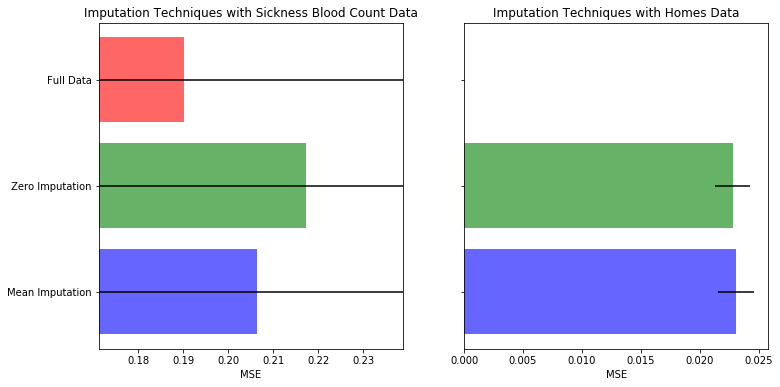

In [8]:
results_sick = np.array(get_results(sickdf))
mses_sick = results_sick[:, 0] * -1
stds_sick = results_sick[:, 1]

results_homes = np.array(get_results(homesdf))
mses_homes = results_homes[:, 0] * -1
stds_homes = results_homes[:, 1]

n_bars = len(mses_sick)
xval = np.arange(n_bars)

x_labels = ['Full Data',
            'Zero Imputation',
            'Mean Imputation']
colors = ['red', 'green', 'blue', 'orange']

# plot sickness results
fig=plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_sick[j], xerr=stds_sick[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Sickness Blood Count Data')
ax1.set_xlim(left=np.min(mses_sick) * 0.9,
             right=np.max(mses_sick) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot homes results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_homes[j], xerr=stds_homes[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with Homes Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()

In [9]:
imagepath = os.path.join(*[os.path.dirname(os.path.dirname(os.getcwd())),'Results','Chapter 03'])
print(imagepath)

C:\Users\AndreVermeulen\Documents\My Book\apress\Industrial Machine Learning\book\GitHub\Upload\industrial-machine-learning\Results\Chapter 03


In [10]:
if not os.path.exists(imagepath):
    os.makedirs(imagepath)

In [11]:
imagename = os.path.join(*[os.path.dirname(os.path.dirname(os.getcwd())),'Results','Chapter 03','Chapter-003-Examples-004-01.jpg'])
fig.savefig(imagename, bbox_inches='tight')

In [12]:
print('Done!')

Done!
